<a href="https://colab.research.google.com/github/russodanielp/intro_cheminformatics/blob/google_colab/Lab%2013%20-%20Deep%20Learning/colab_completed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning

## Aim

To understand the basics of a neural network and to create a simple deep learning neural network using PyTorch.

## Objectives 

* Create a simple deep learning model using PyTorch

## Background

The explosion of the amounts of accessible, publically available data couples with hardware advances such as graphical processing units (GPUs) has lead to the resurgances of deep learning methods.  Deep learning is a catch-all term for various types of artificial neural networks, which have seen in the QSAR lab.  A simple neural network generally consists of one input later, 1 or more hidden layers, and an output layer (__Figure 1__).  However, this framework can be extended to include any number of hidden layers.  When an artificial neural network contains more than 1 hidden layer, it is called a deep neural network.  

<center><img src="https://github.com/russodanielp/intro_cheminformatics/blob/google_colab/Lab%2013%20-%20Deep%20Learning/img/deeplearning.png?raw=1" style="width: 600px;"></img><br><strong>Figure 1.</strong>  A Simple Neural Network.</center>

Part of Python's popularity is the number of deep learning libraries.  The [PyTorch](https://pytorch.org/) is one of the most popular and will be used in this tab to create a fairly standard neural network of 3 hidden layers.  


In this lab we will use a dataset provided by the dataset provided by [NICEATM Acute Oral Toxicity challenge](https://ehp.niehs.nih.gov/doi/10.1289/EHP8495).  In this challenge, over 11,000 chemicals with acute oral toxicity values LD$_{50}$, which is defined as the median concentraion at which 50% of the tested animal subjects die after substance ingestion.  Of these chemicals a training set what provided to modeling participants (labeled `TrainingSet.sdf` in the `data` folder).  We will use this to create a neural network using PyTorch. 

In [6]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import numpy as np
import torch
from torch import nn
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Descriptors
from rdkit import Chem
import pandas as pd
from rdkit.Chem import PandasTools
import math

## Data Preperation

We can prepare the data just as we have for our QSAR methods.

In [8]:
def calc_fp_from_mol(mol, method="maccs", n_bits=2048):
    """
    Encode a molecule from a RDKit Mol into a fingerprint.

    Parameters
    ----------
    mol : RDKit Mol
        The RDKit molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    if method == "maccs":
        return list(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan4":
        return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan6":
        return list(AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return list(MACCSkeys.GenMACCSKeys(mol))

In [9]:
df = PandasTools.LoadSDF('TrainingSetLD50.sdf')
df.head(3)

[21:46:58] Warning: molecule is tagged as 3D, but all Z coords are zero
[21:46:58] Warning: molecule is tagged as 3D, but all Z coords are zero
[21:46:58] Warning: molecule is tagged as 3D, but all Z coords are zero
[21:46:58] Warning: molecule is tagged as 3D, but all Z coords are zero
[21:47:00] WARNING: not removing hydrogen atom with neighbor that has non-tetrahedral stereochemistry
[21:47:02] Warning: molecule is tagged as 3D, but all Z coords are zero
[21:47:03] Warning: molecule is tagged as 3D, but all Z coords are zero
[21:47:03] Warning: molecule is tagged as 3D, but all Z coords are zero


,CASRN,DTXSID,Name,Structure_Source,very_toxic,nontoxic,LD50_mgkg,EPA_category,GHS_category,Original_SMILES,Canonical_QSARr,InChI_Code_QSARr,InChI Key_QSARr,Salt_Solvent,Conv_Info,Enrg_Info,ID,ROMol
0,7545-48-4,,,Public_CrossChecked,FALSE,TRUE,12000.0,4,5,C1=CN(C(=O)NC1=O)C2C(C(C(O2)COP(=O)([O-])[O-])...,OC1C(COP(O)(O)=O)OC(C1O)N1C=CC(=O)NC1=O,InChI=1S/C9H13N2O9P/c12-5-1-2-11(9(15)10-5)8-7...,DJJCXFVJDGTHFX-UHFFFAOYSA-N,[Na+].[Na+],true,-211.68226084448955,17743,<rdkit.Chem.rdchem.Mol object at 0x7f191a7e2120>
1,134528-32-8,,,Public_CrossChecked,FALSE,TRUE,,3,5,C1=C(C(=O)NC(=O)N1C2C(C(C(O2)CO)O)O)C=CBr,OCC1OC(C(O)C1O)N1C=C(C=CBr)C(=O)NC1=O,InChI=1S/C11H13BrN2O6/c12-2-1-5-3-14(11(19)13-...,GCQYYIHYQMVWLT-UHFFFAOYSA-N,?,true,2.7756185873526507,10555,<rdkit.Chem.rdchem.Mol object at 0x7f191a7e2040>
2,17902-23-7,,,Public_CrossChecked,FALSE,FALSE,930.0,3,4,C1CC(OC1)N2C=C(C(=O)NC2=O)F,O=C1NC(=O)C(F)=CN1C1CCCO1,InChI=1S/C8H9FN2O3/c9-5-4-11(6-2-1-3-14-6)8(13...,WFWLQNSHRPWKFK-UHFFFAOYSA-N,?,true,-70.26435136661355,15003,<rdkit.Chem.rdchem.Mol object at 0x7f191a7e24a0>


Let's remove data without LD$_{50}$ data. 

In [10]:
df = df[df.LD50_mgkg != '']
df['LD50_mgkg'] = df['LD50_mgkg'].astype(float)
df.head()

,CASRN,DTXSID,Name,Structure_Source,very_toxic,nontoxic,LD50_mgkg,EPA_category,GHS_category,Original_SMILES,Canonical_QSARr,InChI_Code_QSARr,InChI Key_QSARr,Salt_Solvent,Conv_Info,Enrg_Info,ID,ROMol
0,7545-48-4,,,Public_CrossChecked,FALSE,TRUE,12000.0,4,5,C1=CN(C(=O)NC1=O)C2C(C(C(O2)COP(=O)([O-])[O-])...,OC1C(COP(O)(O)=O)OC(C1O)N1C=CC(=O)NC1=O,InChI=1S/C9H13N2O9P/c12-5-1-2-11(9(15)10-5)8-7...,DJJCXFVJDGTHFX-UHFFFAOYSA-N,[Na+].[Na+],true,-211.68226084448955,17743,<rdkit.Chem.rdchem.Mol object at 0x7f191a7e2120>
2,17902-23-7,,,Public_CrossChecked,FALSE,FALSE,930.0,3,4,C1CC(OC1)N2C=C(C(=O)NC2=O)F,O=C1NC(=O)C(F)=CN1C1CCCO1,InChI=1S/C8H9FN2O3/c9-5-4-11(6-2-1-3-14-6)8(13...,WFWLQNSHRPWKFK-UHFFFAOYSA-N,?,true,-70.26435136661355,15003,<rdkit.Chem.rdchem.Mol object at 0x7f191a7e24a0>
3,27942-00-3,,,Public_CrossChecked,FALSE,TRUE,8150.0,4,5,CN1C=CC(=O)NC1=O,CN1C=CC(=O)NC1=O,"InChI=1S/C5H6N2O2/c1-7-3-2-4(8)6-5(7)9/h2-3H,1...",XBCXJKGHPABGSD-UHFFFAOYSA-N,?,true,-87.22216620737237,17566,<rdkit.Chem.rdchem.Mol object at 0x7f191a7e23c0>
5,80834-51-1,,,Public_CrossChecked,FALSE,FALSE,500.0,2,4,CCC(C(=O)C1=CC2=C(C=C1)NC(=O)C=C2)N3CCN(CC3)C4...,CCC(C(=O)c1cc2C=CC(=O)Nc2cc1)N1CCN(CC1)c1cc(Cl...,InChI=1S/C23H24ClN3O2/c1-2-21(23(29)17-6-8-20-...,LVCUAMMHDAVDEZ-UHFFFAOYSA-N,?,true,144.6181349380037,14260,<rdkit.Chem.rdchem.Mol object at 0x7f191a7e2580>
6,80834-80-6,,,Public_CrossChecked,FALSE,FALSE,500.0,2,4,CCOC1=CC=CC=C1N2CCN(CC2)CCC=CC3=CC4=C(C=C3)NC(...,CCOc1ccccc1N1CCN(CCC=Cc2cc3C=CC(=O)Nc3cc2)CC1,InChI=1S/C25H29N3O2/c1-2-30-24-9-4-3-8-23(24)2...,WTQXWMCWQHOPRX-UHFFFAOYSA-N,?,true,137.79606898256017,14279,<rdkit.Chem.rdchem.Mol object at 0x7f191a7e25f0>


In [11]:
desc_list = []


for mol in df.ROMol.tolist():
    desc = calc_fp_from_mol(mol, method='morgan6', n_bits=1024)
    desc_list.append(desc)

    
X = pd.DataFrame(desc_list)
y = df['LD50_mgkg'].astype(float).apply(lambda x: math.log10(x))

In [12]:
%matplotlib inline

<Axes: >

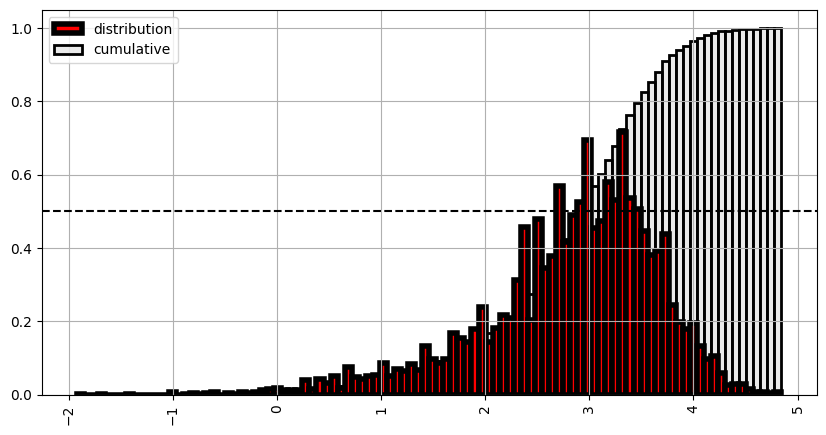

In [13]:
ax = y.hist(bins=100, edgecolor='k', lw=4, facecolor=(1, 0, 0, 1), figsize=(10,5), xrot=90, density=True, label='distribution')
y.hist(cumulative=True, density=1, bins=100, label='cumulative', zorder=0, facecolor=(0.8, 0.8, 0.8, 0.4), edgecolor='k', lw=2, figsize=(10,5))
ax.axhline(0.5, ls='--', c='k')
ax.legend()
ax

The above plot shows that about half the LD50 data points lie above a log(3) and half lie below, so we can use that as our activitiy classification cutoffs.  

We need to validate our model.  A typical DNN is usually trained on hundreds to thousands of data points and need to optimize millions of parameters.  For this type of scenario, cross validation as we did in the QSAR lab, would require splitting our data into multiple tests sets, which is often not practical without the help of a (or several) GPU(s).  

For validation, we will split our data into a validation set consisting of 20% of our compounds.  

In [14]:
from sklearn.model_selection import KFold, train_test_split
SEED = 2008


y_binary = y.copy()
y_binary[y < 3] = 1
y_binary[y >= 3] = 0

# from sklearn.preprocessing import OneHotEncoder

# enc = OneHotEncoder(handle_unknown='ignore')

# y_binary = enc.fit_transform(y_binary.values.reshape(-1, 1)).toarray()

X_train, X_val, y_train, y_val = train_test_split(X, y_binary , test_size=0.2, random_state=SEED)

X_train, X_val, y_train, y_val = X_train.values.astype('float32'), X_val.values.astype('float32'), y_train.values.astype('float32'), y_val.values.astype('float32')

## Model Building

Building a deep learning network requires knowledge of how to create a `class` and objects in Python.  It's beyond the scope of this lab, but in the cell below a simple deep neural network of 2 hidden layers has been created for you.  

In [15]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, in_features=1024, 
                 out_features=1):
        super().__init__()
        self.input = nn.Linear(in_features=in_features,
                             out_features=100)
        self.hl_1 = nn.Linear(in_features=100, 
                             out_features=100)
        self.hl_2 = nn.Linear(in_features=100, 
                             out_features=100)
        self.hl_3 = nn.Linear(in_features=100, 
                             out_features=100)
        self.output = nn.Linear(in_features=100,  
                             out_features=out_features)
        
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, X):
        X = nn.functional.relu(self.input(X))
        X = self.dropout(X)
        X = nn.functional.relu(self.hl_1(X))
        X = self.dropout(X)
        X = nn.functional.relu(self.hl_2(X))
        X = self.dropout(X)
        X = nn.functional.relu(self.hl_3(X))
        X = self.dropout(X)
        return nn.functional.sigmoid(self.output(X))

In [16]:
model = NeuralNetwork().to('cpu')
print(model)

NeuralNetwork(
  (input): Linear(in_features=1024, out_features=100, bias=True)
  (hl_1): Linear(in_features=100, out_features=100, bias=True)
  (hl_2): Linear(in_features=100, out_features=100, bias=True)
  (hl_3): Linear(in_features=100, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


After designing the neural network we need to decide which methods we need to train.  For this we will use [Adam optimization, an extension of stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) and define a [loss function](https://en.wikipedia.org/wiki/Loss_function), which in our case is [binary cross entropy](https://en.wikipedia.org/wiki/Binary_entropy_function).  

In [17]:
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

## Model training

Model training a neural network works by taking epochs, also known as steps.  Mathematically, it is an optimization problem where we are trying to find the neural network parameters which minimize the loss function.  In this case our loss function is binary cross entroy, which is how well our model is predicting our classes (0, 1).  After every epoch, the loss is calculated and for each parameters some calculus is applied to figure our which way we should adjust these parameters such that the loss will be lower the next epoch.  This is usually repeated until some specified number of training epochs or some other stopping point.  

__NOTE:__  Depending on the your CPU hardware, training the model by running the cell below could take a significant time period.  

In [18]:
EPOCHS = 500
losses = []

for epoch in range(EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0


    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(torch.from_numpy(X_train))
    loss = criterion(outputs, torch.from_numpy(y_train.reshape(-1, 1)))

    loss.backward()
    optimizer.step()
        
    # print statistics
    running_loss += loss.item()
    losses.append(loss.item())
    if epoch % 100 == 0:
        print(f"Finished training epoch {epoch}, training loss is at {loss.item()}")

print('Finished Training')

Finished training epoch 0, training loss is at 0.6944959163665771
Finished training epoch 100, training loss is at 0.02375253103673458
Finished training epoch 200, training loss is at 0.024050377309322357
Finished training epoch 300, training loss is at 0.023371314629912376
Finished training epoch 400, training loss is at 0.02005801536142826
Finished Training


## Training Plots

It's often common to monitor the loss function throughout to make sure your deep learning network is progressing as expected.  Typically, you should see the loss start out high, and gradually slope to a plateau.  If the slope is too steep, it could meant the learning rate is too high.  If it's more linear, than your learning rate could be too low.  

In [19]:
%matplotlib inline

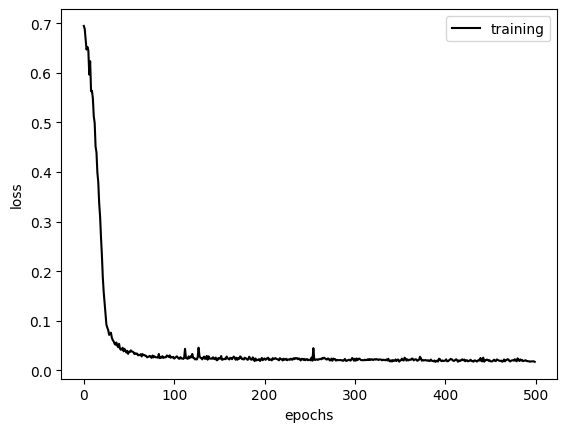

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(range(EPOCHS), losses, c='k', label='training')

ax.set_ylabel('loss')
ax.set_xlabel('epochs')
ax.legend()
plt.show()

We can calcuate the statistics on both the validation set to assess model performance as we did before in the QSAR module.  

First we use our model to predict the validation set.  Predictions are provided as probability of being toxic and we can view these for both the training compounds and the validation compounds. 

In [21]:
with torch.no_grad():
    train_predictions =  model(torch.from_numpy(X_train)).numpy()
    val_predictions =  model(torch.from_numpy(X_val)).numpy()

train_predictions = pd.DataFrame([train_predictions[:, 0], y_train], index=['Prediction', 'Toxic Class']).T   
val_predictions = pd.DataFrame([val_predictions[:, 0], y_val], index=['Prediction', 'Toxic Class']).T   

Text(0.5, 1.0, 'Training Set Predictions')

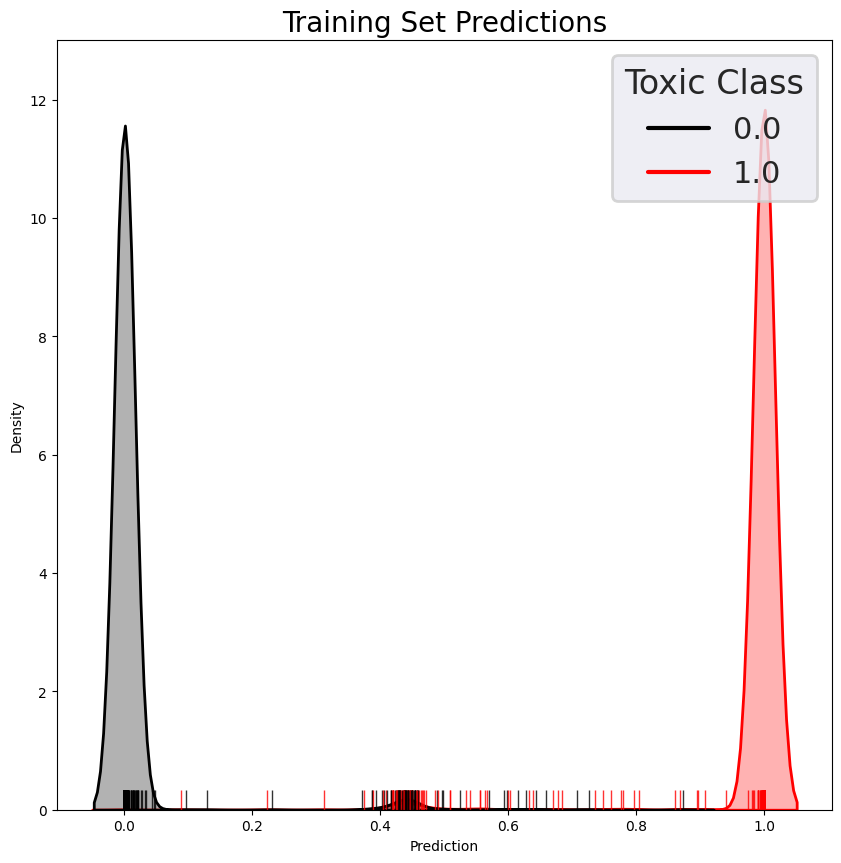

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

palette = {
    1: (1, 0, 0, 0.8),
    0: (0, 0, 0, 0.8)
}


sns.set()
sns.set_context('poster')

sns.kdeplot(data=train_predictions, x="Prediction", hue='Toxic Class', palette=palette, fill=True, alpha=0.3)
sns.rugplot(data=train_predictions, x="Prediction", hue='Toxic Class', palette=palette)

ax.set_title('Training Set Predictions', fontsize=20)

Text(0.5, 1.0, 'Validation Set Predictions')

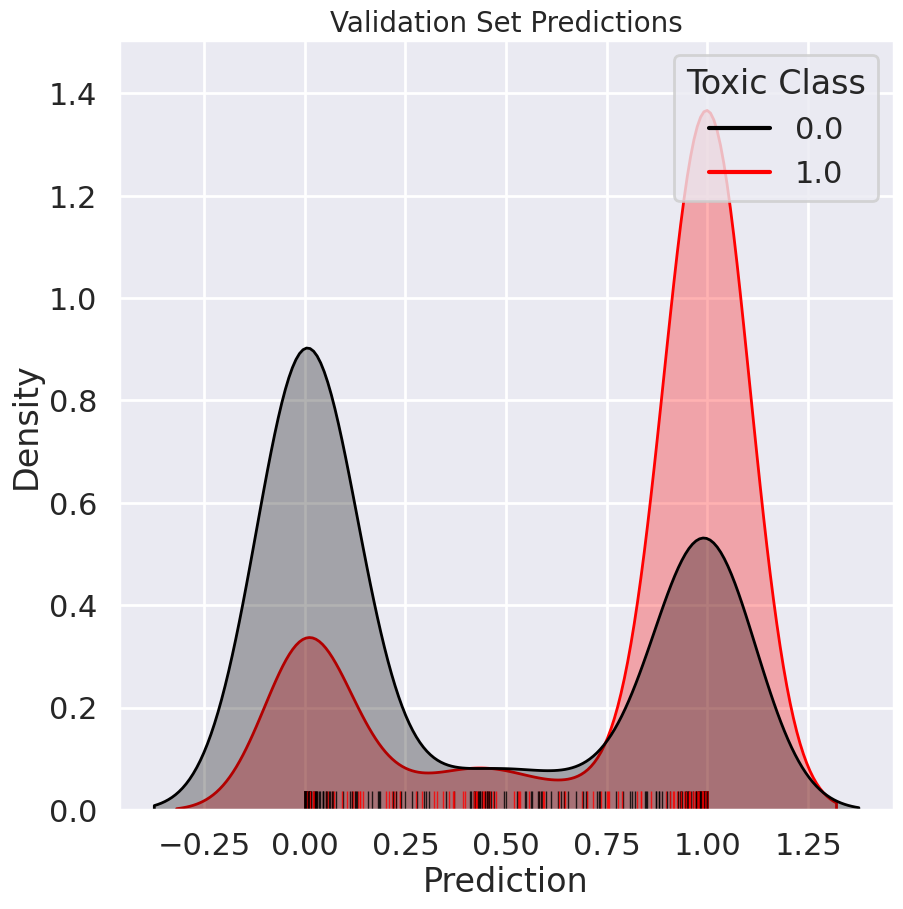

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.kdeplot(data=val_predictions, x="Prediction", hue='Toxic Class', palette=palette, fill=True, alpha=0.3)
sns.rugplot(data=val_predictions, x="Prediction", hue='Toxic Class', palette=palette)

ax.set_title('Validation Set Predictions', fontsize=20)

In [24]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score

def calc_stats(preds_frame):
    preds_copy = preds_frame.copy()
    preds_copy.loc[preds_frame['Prediction'] > 0.5, 'Prediction'] = 1
    preds_copy.loc[preds_frame['Prediction'] <= 0.5, 'Prediction'] = 0
    
    accuracy = accuracy_score(preds_copy['Toxic Class'], preds_copy['Prediction'])
    sens = recall_score(preds_copy['Toxic Class'], preds_copy['Prediction'])
    spec = recall_score(preds_copy['Toxic Class'], preds_copy['Prediction'], pos_label=0)
    auc = roc_auc_score(preds_copy['Toxic Class'], preds_copy['Prediction'])
    
    return {"accuracy": accuracy, "sensitivity": sens, "specificity": spec, "AUROC": auc}

training_stats = calc_stats(train_predictions)
validation_stats = calc_stats(val_predictions)

for _ in range(2): print("")

print(" TRAINING SET STATISTICS ")
for stat, val in training_stats.items():
    print(f" {stat.upper()} is {val} ")

for _ in range(2): print("")
    
print(" VALIDATION SET STATISTICS ")
for stat, val in validation_stats.items():
    print(f" {stat.upper()} is {val} ")




 TRAINING SET STATISTICS 
 ACCURACY is 0.9890477074438463 
 SENSITIVITY is 0.9828632631203141 
 SPECIFICITY is 0.9957463263727765 
 AUROC is 0.9893047947465452 


 VALIDATION SET STATISTICS 
 ACCURACY is 0.6933927245731255 
 SENSITIVITY is 0.764792899408284 
 SPECIFICITY is 0.6214605067064084 
 AUROC is 0.693126703057346 
